In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render())

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done = env.step(action)
            img = env.render()
            frames.append(img)
            state = next_state

    return display_video(frames)


def reset_seed_everything(env: gym.Env, seed: int = 42):
    state = env.reset(seed=seed)[0]
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    return state


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()



In [2]:
import random
import copy
import gym
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# test_agent, plot_stats

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


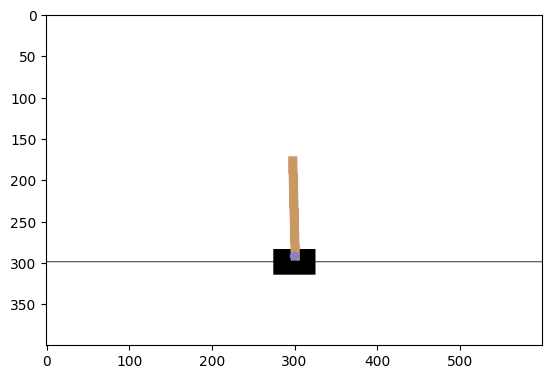

In [3]:
env = gym.make("CartPole-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [4]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.step(1)

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.00708425,  0.18748564, -0.0208042 , -0.31177402], dtype=float32),
 1.0,
 False,
 False,
 {})

In [5]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()[0]
        return torch.from_numpy(state).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, _, _ = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.from_numpy(np.array(reward)).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done= env.step(action)
print(f"Sample state: {state}")
print(f"Next_state: {next_state}, Reward: {reward}, Done: {done}")


Sample state: tensor([[ 0.0247,  0.0017,  0.0352, -0.0101]])
Next_state: tensor([[ 0.0247, -0.1939,  0.0350,  0.2935]]), Reward: tensor([[1.]]), Done: tensor([[False]])


In [8]:
q_network = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, action_dim)
)

In [9]:
target_q_network = copy.deepcopy(q_network).eval()

In [10]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(action_dim, (len(state), 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=1, keepdim=True)

In [11]:
class ReplayMemory:
    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items, dim=0) for items in batch]
    
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10
    
    def __len__(self):
        return len(self.memory)

In [12]:
def deep_q_learning(
    q_network,
    target_q_network,
    policy,
    episodes,
    alpha=0.0001,
    batch_size=32,
    gamma=0.99,
    epsilon=0.2,
):
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=alpha)
    loss_fn = torch.nn.MSELoss()
    memory = ReplayMemory(capacity=1000000)
    stats = {"MSE Loss": [], "Returns": []}

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done = env.step(action)
            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(
                    batch_size
                )
                qsa_b = q_network(state_b).gather(1, action_b)
                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                loss = loss_fn(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optimizer.step()

                stats["MSE Loss"].append(loss.item())

            state = next_state
            ep_return += reward

        stats["Returns"].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats



In [16]:
stats = deep_q_learning(q_network, target_q_network, policy, episodes=500)

  0%|          | 0/500 [00:00<?, ?it/s]

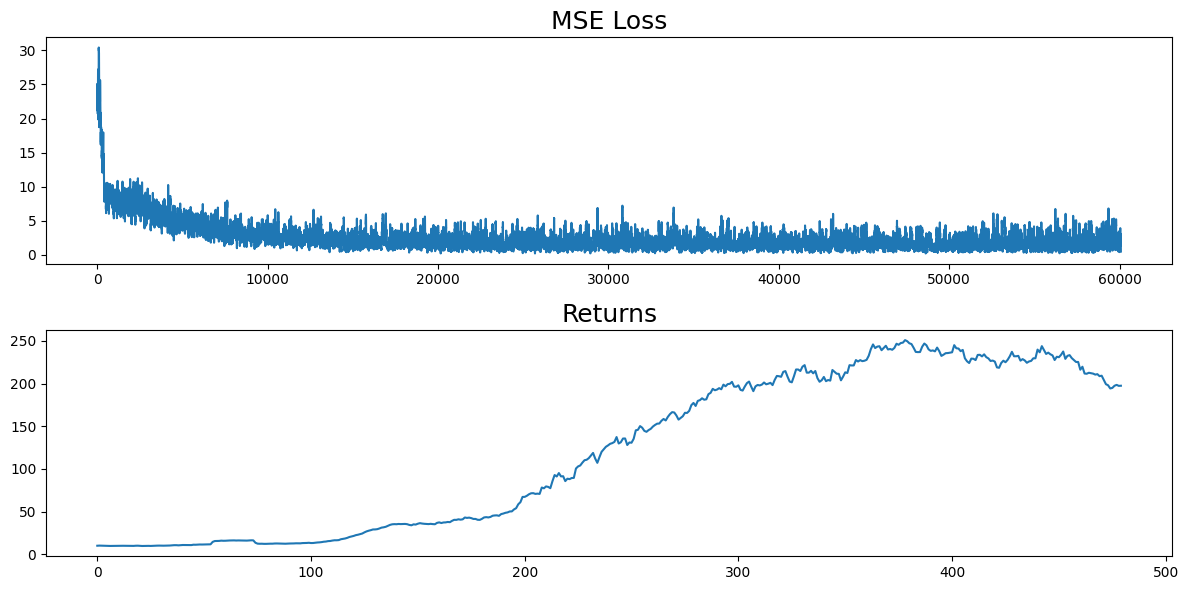

In [17]:
plot_stats(stats)

In [18]:
test_agent(env, policy, episodes=10)